In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
import ubelt as ub
import pint
site.addsitedir('../../../ARGUS')
from ARGUS_Transforms import ARGUS_RandSpatialCropSlicesd  #NOQA
Ureg = pint.UnitRegistry()

In [2]:
img1_dir = "../../Data_PNB/annotations_yuri/"
img2_dir = "../../Data_PNB_resized/annotations_yuri/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_cropM.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.overlay.mha')))

num_devices = 1
gpu_device = 1

num_classes = 2

net_in_dims = 2 # Spatial Dimensions
net_in_channels = 3 # Rawframe, Mean and Std
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)
        
num_folds = 13

num_slice = 32
size_x = 320
size_y = 640

num_workers_te = 2
batch_size_te = 2

model_filename_base = "./results/BAMC_PNB_ARUNet-3D-RawFrame_StdDevOverTime-yuriArteryData-32s-VFold"

model_type = "best"  #"best" or "last"

In [3]:
model_filename_base = model_filename_base+"/"
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

p_prefix = ['3. 11 AC_Video 2',
            '3. 67 AC_Video 2', 
            '3. 93 AC_Video 2', 
            '3. 94 AC_Video 2', 
            '3. 134 AC_Video 2', 
            '3. 189 AC_Video 2', 
            '3. 205 AC_Video 2',
            '3. 217 AC_Video 2', 
            '3. 238 AC_Video 2', 
            '4. 211 AC_Video 3', 
            '4. 222A_Video 2',  
            '5. 153 AC_Video 3', 
            '5. 240 AC_Video 3',  
            '7. 193 AC Video 4']

n_prefix = ['1. 57 AC_Video 1',
            '1. 134 AC_Video 1',
            '1. 136 AC_Video 1', 
            '1. 179 AC_Video 1', 
            '1. 189 AC_Video 1', 
            '1. 204 AC Video 1', 
            '1. 205 AC_Video 1', 
            '1. 217 AC_Video 1', 
            '1. 238 AC_Video 1',  
            '2. 39 AC_Video 2',
            '5. 191 AC_Video 5']


fold_prefix_list = []
p_count = 0
n_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_p = 1
        num_n = 1
        if i > num_folds-2:
            num_p = 2
    else:
        num_p = 1
        num_n = 1
    f = []
    if p_count < len(p_prefix):
        for p in range(num_p):
            f.append([p_prefix[p_count+p]])
    p_count += num_p
    if n_count < len(n_prefix):
        for n in range(num_n):
            f.append([n_prefix[n_count+n]])
    n_count += num_n
    fold_prefix_list.append(f)

for i in range(num_folds):
    print(i, fold_prefix_list[i])

Num images / labels = 25 25
0 [['3. 11 AC_Video 2'], ['1. 57 AC_Video 1']]
1 [['3. 67 AC_Video 2'], ['1. 134 AC_Video 1']]
2 [['3. 93 AC_Video 2'], ['1. 136 AC_Video 1']]
3 [['3. 94 AC_Video 2'], ['1. 179 AC_Video 1']]
4 [['3. 134 AC_Video 2'], ['1. 189 AC_Video 1']]
5 [['3. 189 AC_Video 2'], ['1. 204 AC Video 1']]
6 [['3. 205 AC_Video 2'], ['1. 205 AC_Video 1']]
7 [['3. 217 AC_Video 2'], ['1. 217 AC_Video 1']]
8 [['3. 238 AC_Video 2'], ['1. 238 AC_Video 1']]
9 [['4. 211 AC_Video 3'], ['2. 39 AC_Video 2']]
10 [['4. 222A_Video 2'], ['5. 191 AC_Video 5']]
11 [['5. 153 AC_Video 3']]
12 [['5. 240 AC_Video 3'], ['7. 193 AC Video 4']]


In [4]:
total_bytes = 0
for p in all_images:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

total_bytes = 0
for p in all_labels:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

2.4898208379745483 gibibyte
0.012278499081730843 gibibyte


In [5]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    va_folds = []
    for f in range(i,i+num_folds-4):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    for f in range(i+num_folds-4, i+num_folds-1):
        va_folds.append(fold_prefix_list[f%num_folds])
    va_folds = list(np.concatenate(va_folds).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

18 5 2
18 5 2
18 5 2
17 6 2
17 6 2
17 6 2
17 6 2
17 6 2
17 6 2
17 6 2
17 6 2
17 6 2
18 6 1


In [6]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slice,1],
            center_slice=num_slice/2,
            axis=0,
            reduce_to_statistics=[True,False],
            extended=False,
            include_img=True,
            keys=['image','label']),
        Resized(
            spatial_size=(-1,640),
            mode=["bilinear","nearest"],
            keys=['image','label']
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

In [7]:
device = torch.device("cuda:"+str(gpu_device))

In [9]:
def plot_vfold_training_curves(vfold_num, test_loader):
    print("VFOLD =", vfold_num, "of", num_folds - 1)

    loss_file = model_filename_base+"loss_"+str(vfold_num)+".npy"
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
        metric_file = model_filename_base+"val_dice_"+str(vfold_num)+".npy"
        metric_values = np.load(metric_file)
    
        plt.figure("train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Epoch Average Loss")
        x = [i + 1 for i in range(len(epoch_loss_values))]
        y = epoch_loss_values
        plt.xlabel("epoch")
        plt.plot(x, y)
        plt.subplot(1, 2, 2)
        plt.title("Val Mean Dice")
        x = [2 * (i + 1) for i in range(len(metric_values))]
        y = metric_values
        plt.xlabel("epoch")
        plt.plot(x, y)
        plt.show()
    else:
        print("  File not found:", loss_file)
    
    model_file = model_filename_base+model_type+'_model.vfold_'+str(vfold_num)+'.pth'
    if os.path.exists(model_file):
        model = UNet(
            dimensions=net_in_dims,
            in_channels=net_in_channels,
            out_channels=num_classes,
            channels=net_channels,
            strides=net_strides,
            num_res_units=2,
            norm=Norm.BATCH,
    ).to(device)
        dice_metric = DiceMetric(include_background=False, reduction="mean")
        post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
        post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])   
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            i = 0
            for b,test_data in enumerate(test_loader):
                roi_size = (size_x, size_y)
                sw_batch_size = 1
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, sw_batch_size, model
                )
                test_labels = test_data["label"].to(device)
                test_outputs_list = [post_pred(i) for i in decollate_batch(test_outputs)]
                test_labels_list = [post_label(i) for i in decollate_batch(test_labels)]

                dice_metric(y_pred=test_outputs_list, y=test_labels_list)
                metric = dice_metric.aggregate().item()
                print("Average test dice score for Vfold " + str(vfold_num) + " = " +str(metric))
                dice_metric.reset()
                
                for j in range(test_outputs.shape[0]):
                    print(test_files[vfold_num][i]["image"])
                    plt.figure("check", (18, 6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    tmpV = test_data["image"][j, 0, :, :]
                    plt.imshow(tmpV, cmap="gray")
                    plt.subplot(1, 3, 2)
                    plt.title(f"label {i}")
                    tmpV = test_data["label"][j, 0, :, :]
                    tmpV[0,0]=1
                    tmpV[0,1]=2
                    plt.imshow(tmpV)
                    plt.subplot(1, 3, 3)
                    plt.title(f"output {i}")
                    maxZ = test_outputs[j,:,:,:]
                    mC = np.zeros([maxZ.shape[1],maxZ.shape[2]])
                    for x in range(maxZ.shape[1]):
                        for y in range(maxZ.shape[2]):
                            m1 = 0
                            m2 = 0
                            m1C = 0
                            for c in range(num_classes):
                                if maxZ[c,x,y] > m2:
                                    m2 = maxZ[c,x,y]
                                if maxZ[c,x,y] > m1:
                                    m2 = m1
                                    m1 = maxZ[c,x,y]
                                    m1C = c
                            if m1>0.95 and m1-m2>0.4:
                                mC[x,y] = m1C
                    tmpV[0,0]=1
                    tmpV[0,1]=2
                    mC[0,0]=1
                    mC[0,1]=2
                    plt.imshow(mC)
                    plt.show()
                    i += 1
    else:
        print("  File not found:", model_file)


Loading dataset: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]

VFOLD = 0 of 12


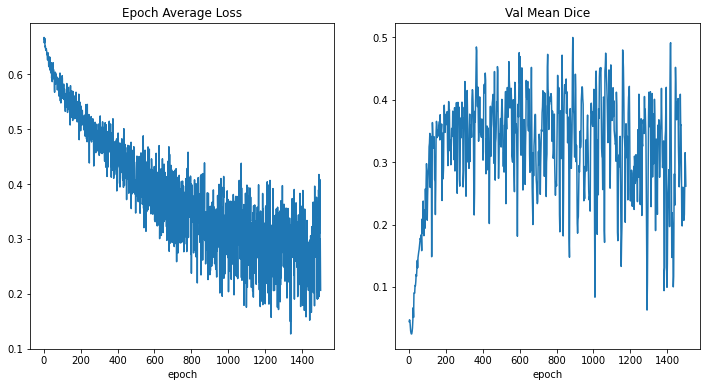

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 0 = 0.28889164328575134
../../Data_PNB/annotations_yuri/5. 240 AC_Video 3_cropM.nii.gz


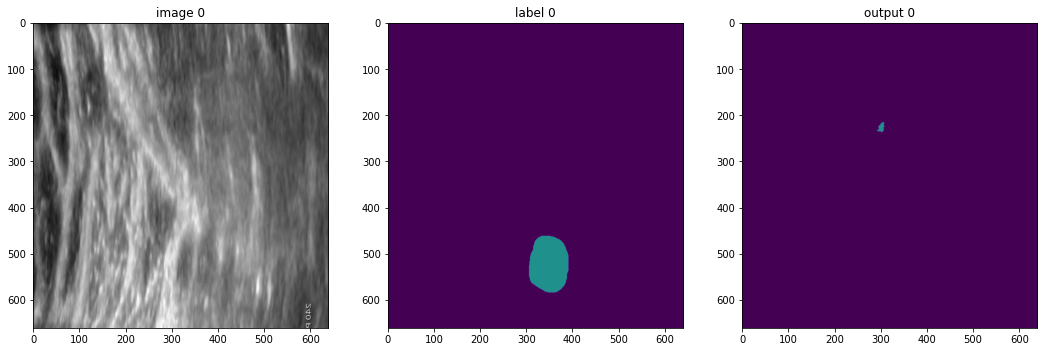

../../Data_PNB/annotations_yuri/7. 193 AC Video 4_cropM.nii.gz


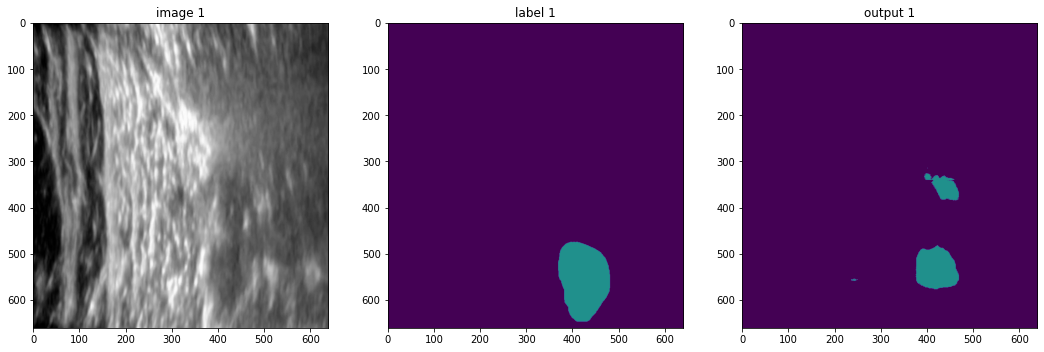

Loading dataset: 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

VFOLD = 1 of 12


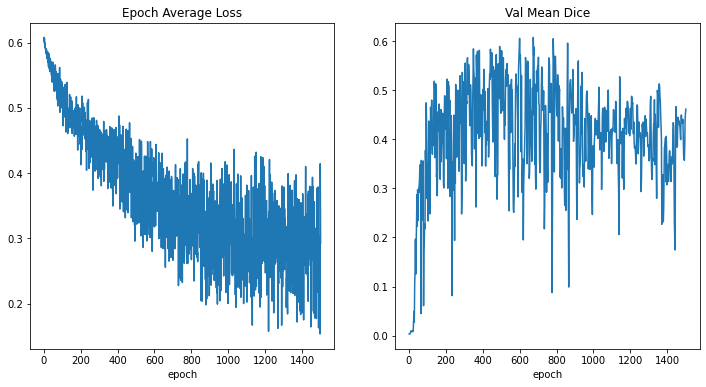

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 1 = 0.3952327370643616
../../Data_PNB/annotations_yuri/1. 57 AC_Video 1_cropM.nii.gz


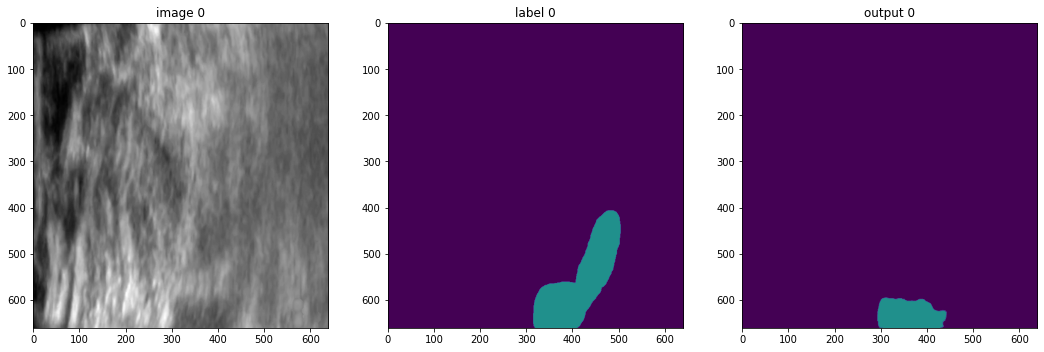

../../Data_PNB/annotations_yuri/3. 11 AC_Video 2_cropM.nii.gz


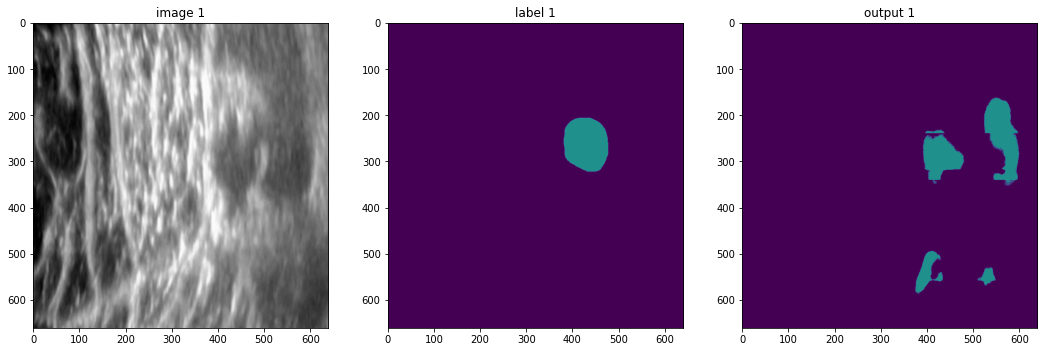

Loading dataset: 100%|██████████| 2/2 [00:07<00:00,  3.66s/it]

VFOLD = 2 of 12


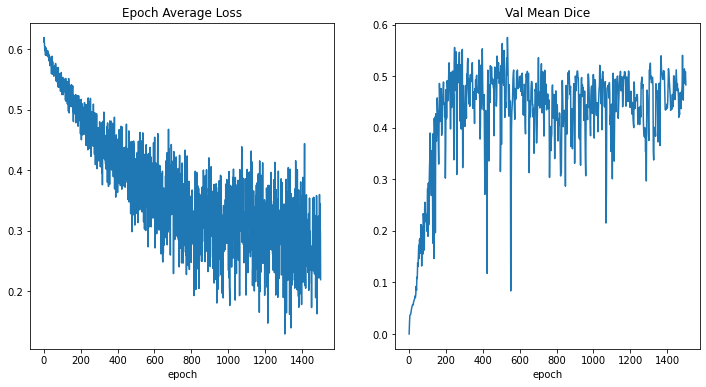

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 2 = 0.05384087935090065
../../Data_PNB/annotations_yuri/1. 134 AC_Video 1_cropM.nii.gz


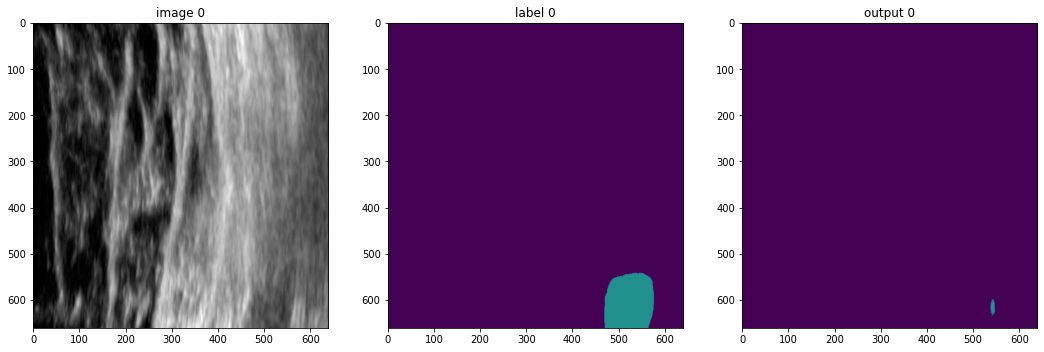

../../Data_PNB/annotations_yuri/3. 67 AC_Video 2_cropM.nii.gz


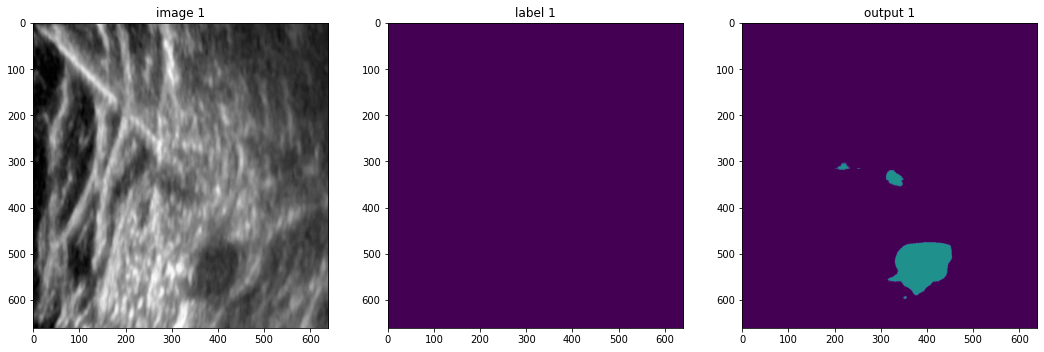

Loading dataset: 100%|██████████| 2/2 [00:05<00:00,  2.93s/it]

VFOLD = 3 of 12


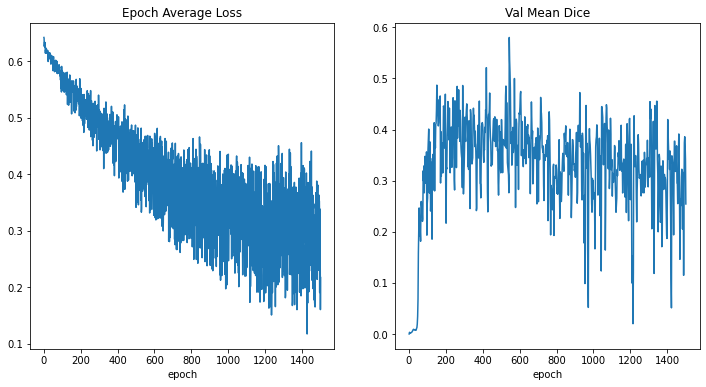

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 3 = 0.3671400547027588
../../Data_PNB/annotations_yuri/1. 136 AC_Video 1_cropM.nii.gz


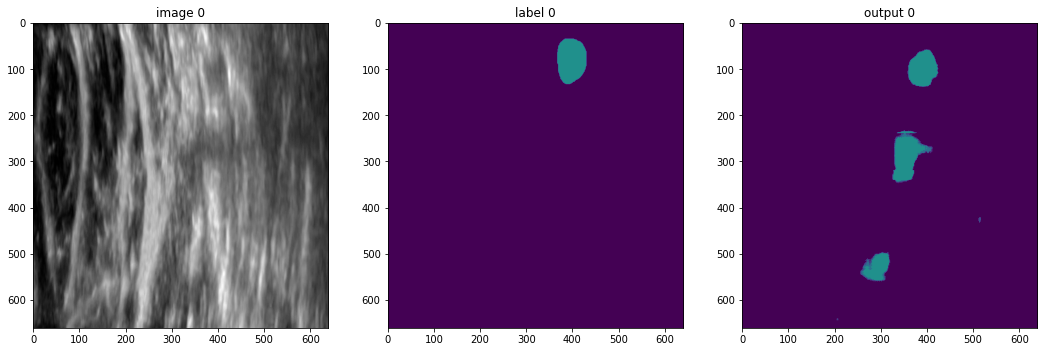

../../Data_PNB/annotations_yuri/3. 93 AC_Video 2_cropM.nii.gz


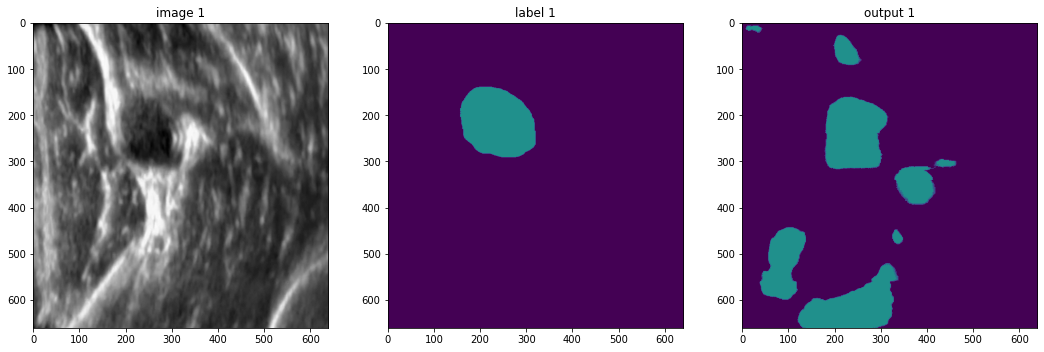

Loading dataset: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


VFOLD = 4 of 12


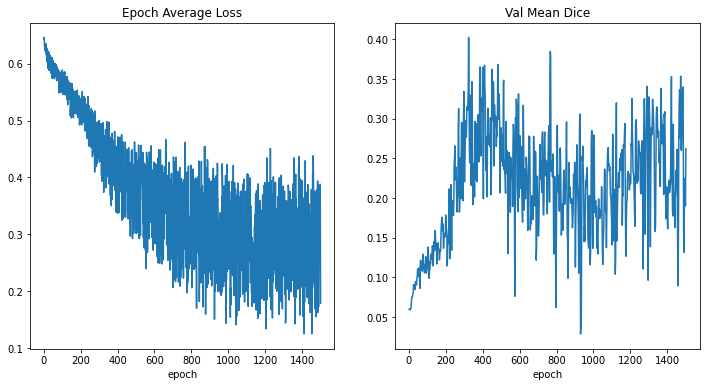

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 4 = 0.36727333068847656
../../Data_PNB/annotations_yuri/1. 179 AC_Video 1_cropM.nii.gz


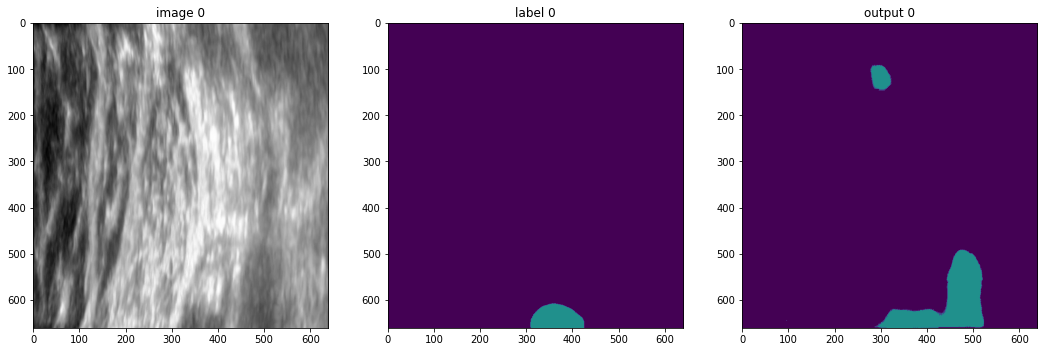

../../Data_PNB/annotations_yuri/3. 94 AC_Video 2_cropM.nii.gz


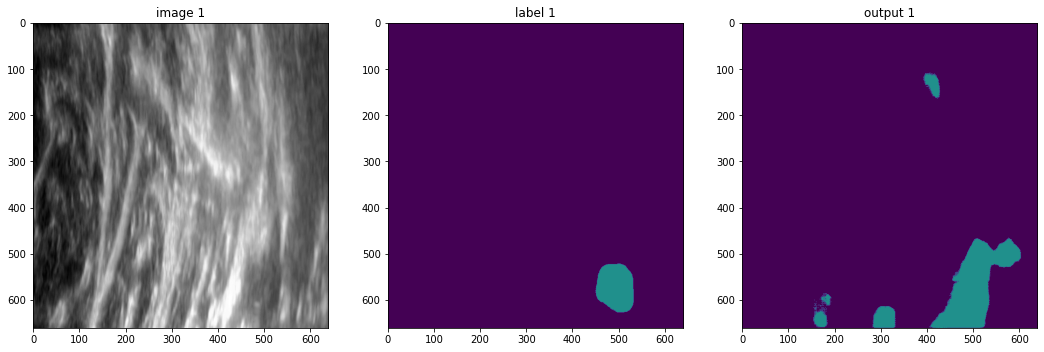

Loading dataset: 100%|██████████| 2/2 [00:05<00:00,  2.79s/it]

VFOLD = 5 of 12


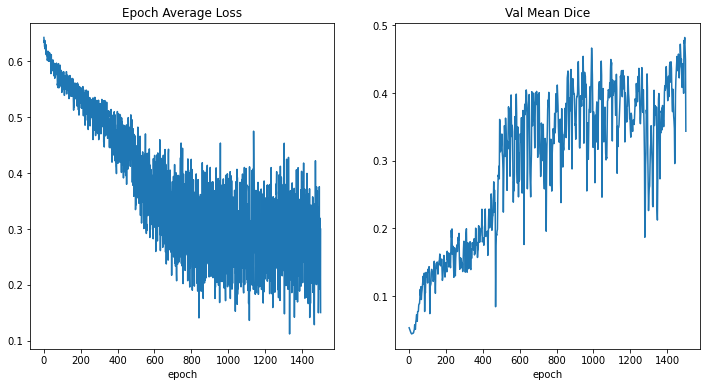

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 5 = 0.6006703972816467
../../Data_PNB/annotations_yuri/1. 189 AC_Video 1_cropM.nii.gz


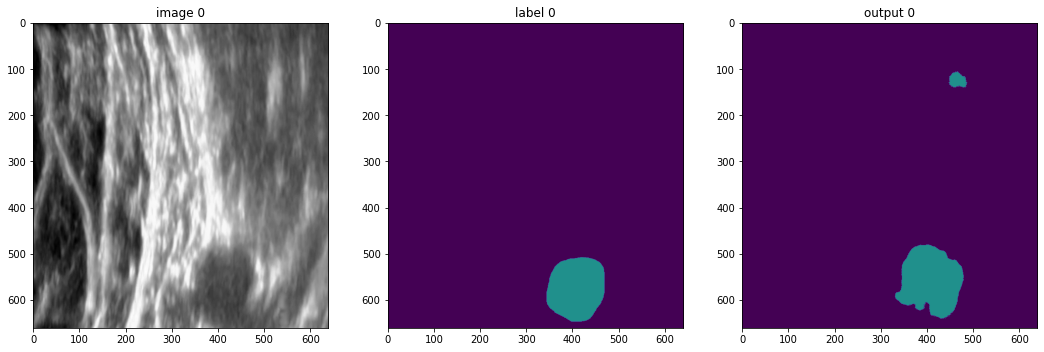

../../Data_PNB/annotations_yuri/3. 134 AC_Video 2_cropM.nii.gz


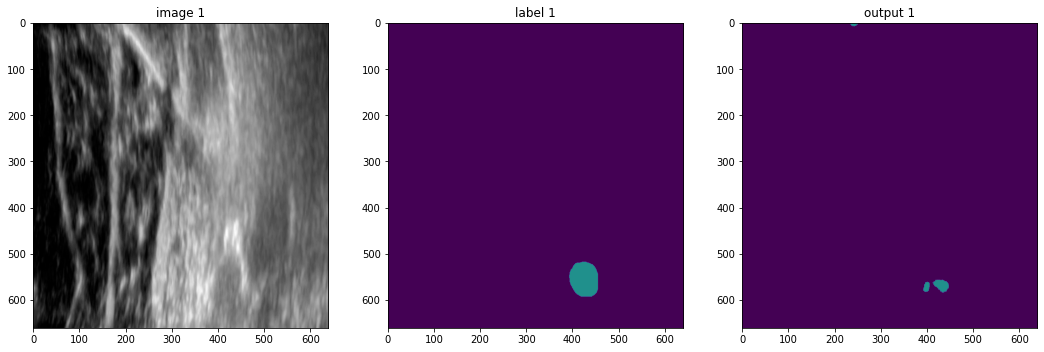

Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]

VFOLD = 6 of 12


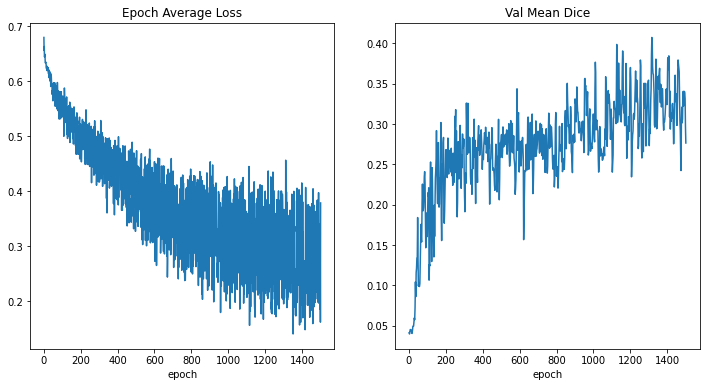

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 6 = 0.24131637811660767
../../Data_PNB/annotations_yuri/1. 204 AC Video 1_cropM.nii.gz


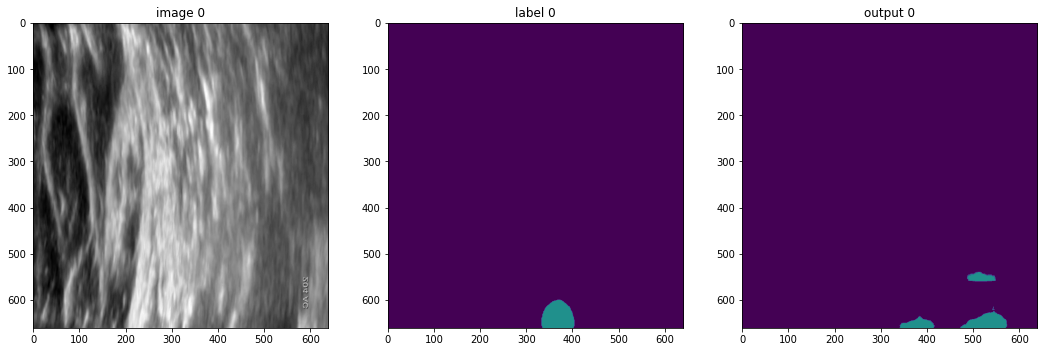

../../Data_PNB/annotations_yuri/3. 189 AC_Video 2_cropM.nii.gz


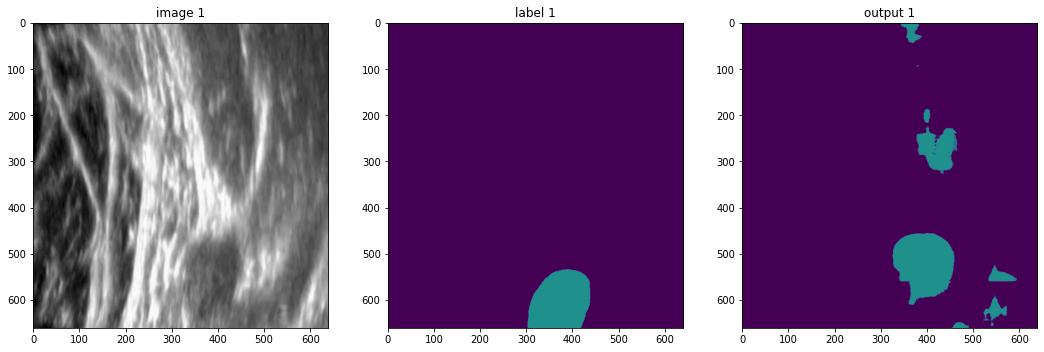

Loading dataset: 100%|██████████| 2/2 [00:06<00:00,  3.14s/it]

VFOLD = 7 of 12


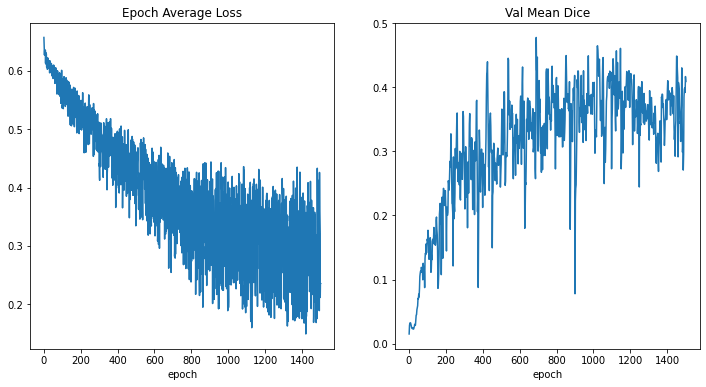

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 7 = 0.12706615030765533
../../Data_PNB/annotations_yuri/1. 205 AC_Video 1_cropM.nii.gz


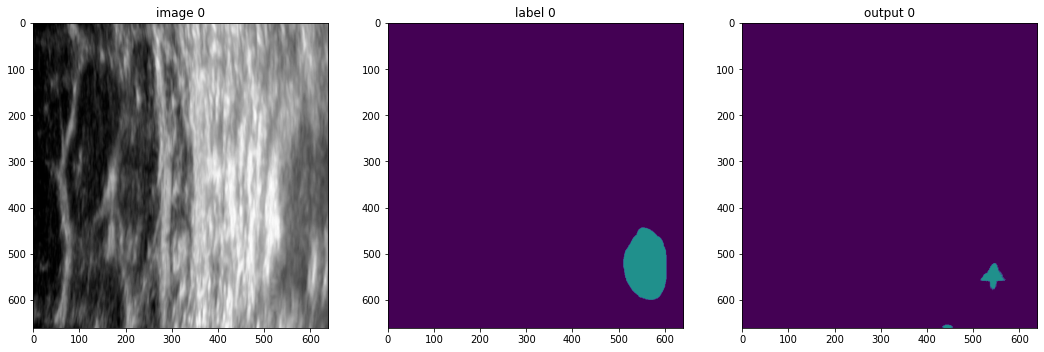

../../Data_PNB/annotations_yuri/3. 205 AC_Video 2_cropM.nii.gz


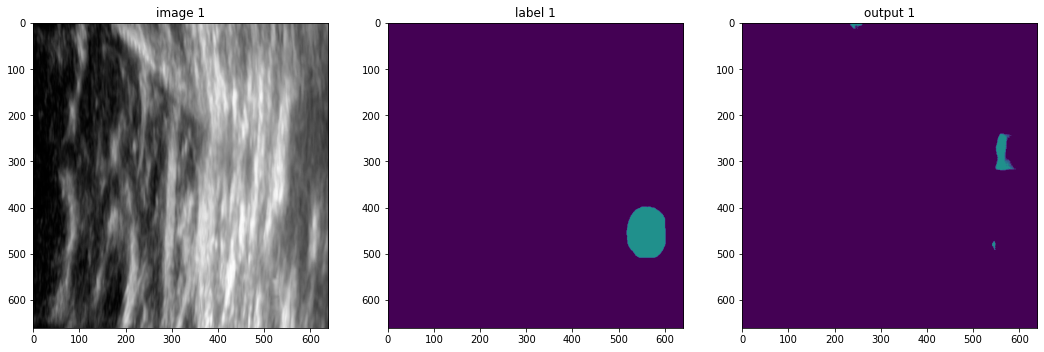

Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]

VFOLD = 8 of 12


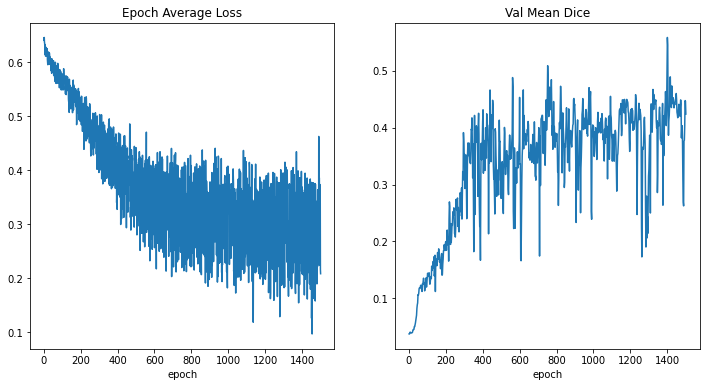

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 8 = 0.5359610319137573
../../Data_PNB/annotations_yuri/1. 217 AC_Video 1_cropM.nii.gz


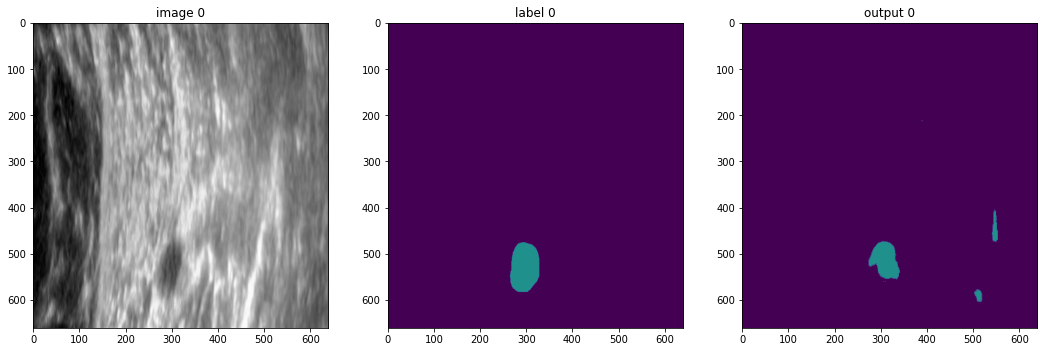

../../Data_PNB/annotations_yuri/3. 217 AC_Video 2_cropM.nii.gz


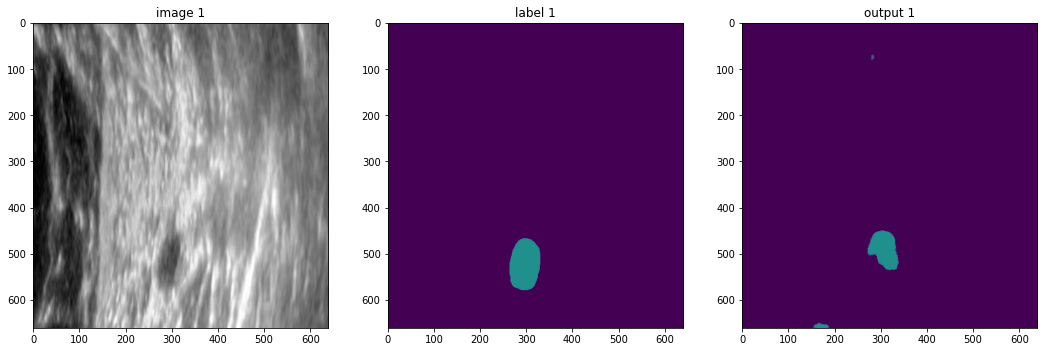

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

VFOLD = 9 of 12


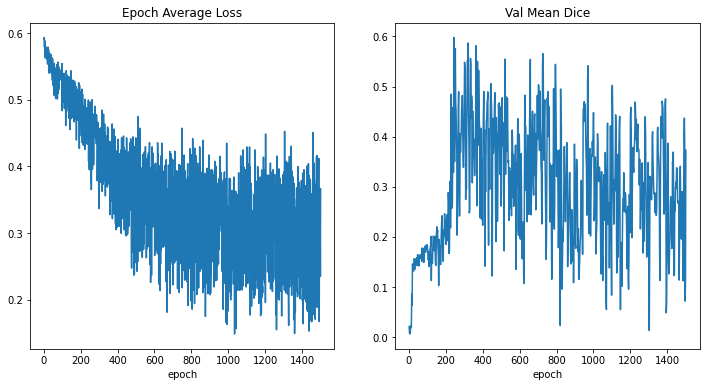

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 9 = 0.683430016040802
../../Data_PNB/annotations_yuri/1. 238 AC_Video 1_cropM.nii.gz


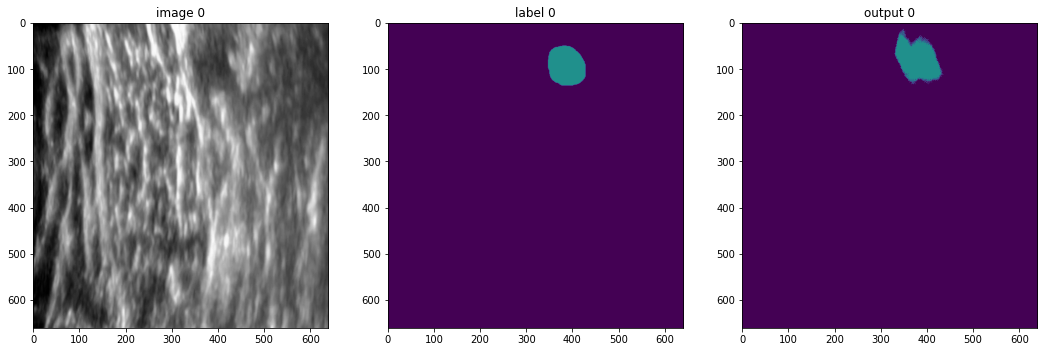

../../Data_PNB/annotations_yuri/3. 238 AC_Video 2_cropM.nii.gz


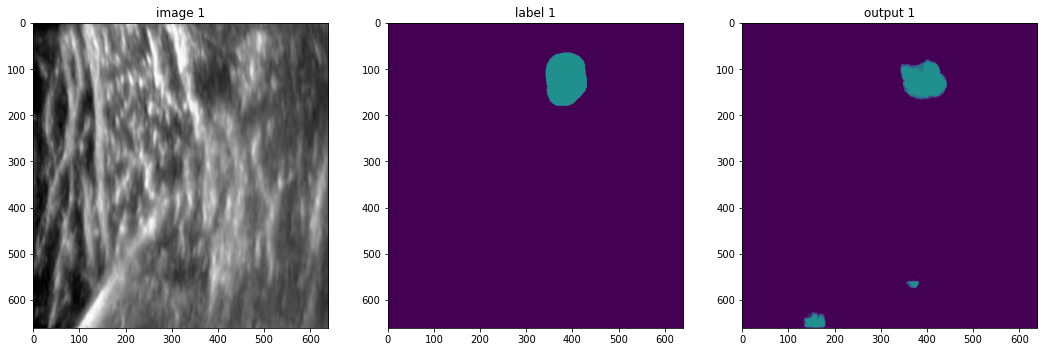

Loading dataset: 100%|██████████| 2/2 [00:08<00:00,  4.47s/it]

VFOLD = 10 of 12


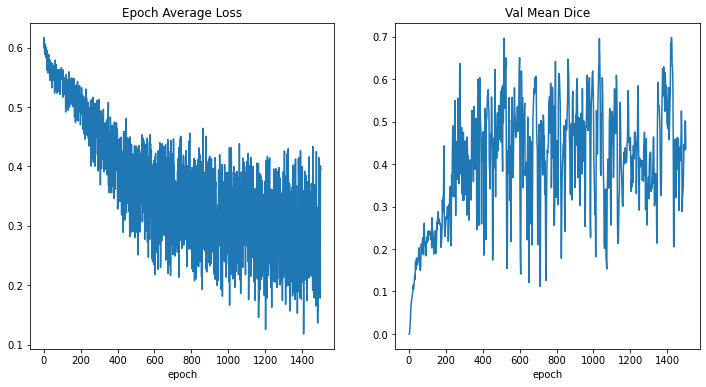

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 10 = 0.04207427054643631
../../Data_PNB/annotations_yuri/2. 39 AC_Video 2_cropM.nii.gz


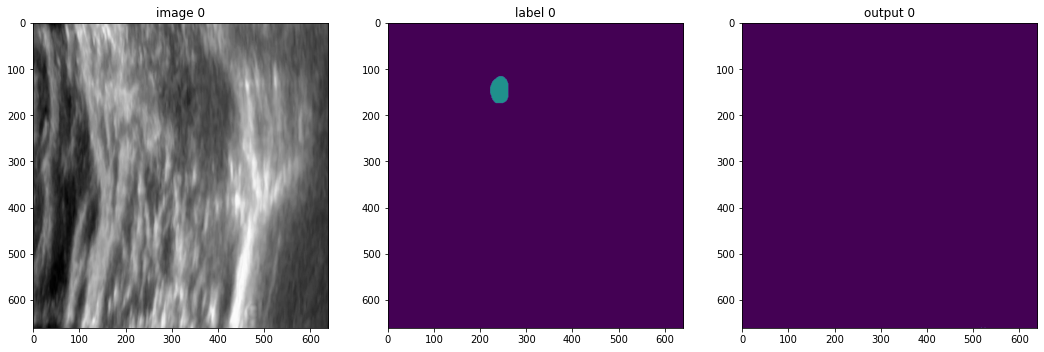

../../Data_PNB/annotations_yuri/4. 211 AC_Video 3_cropM.nii.gz


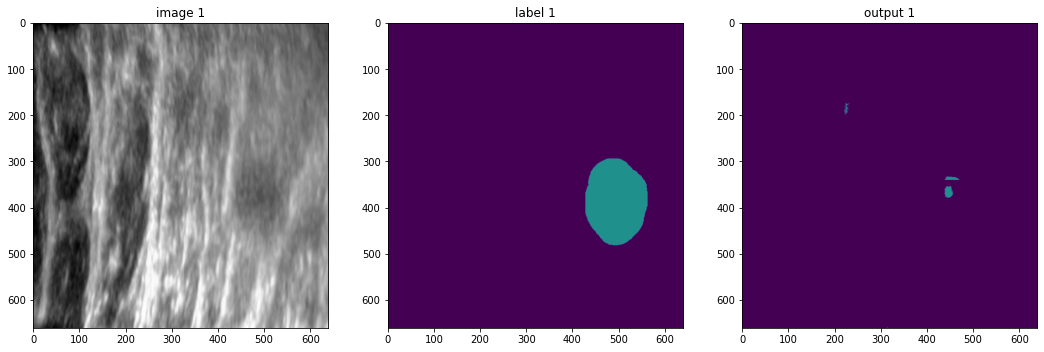

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


VFOLD = 11 of 12


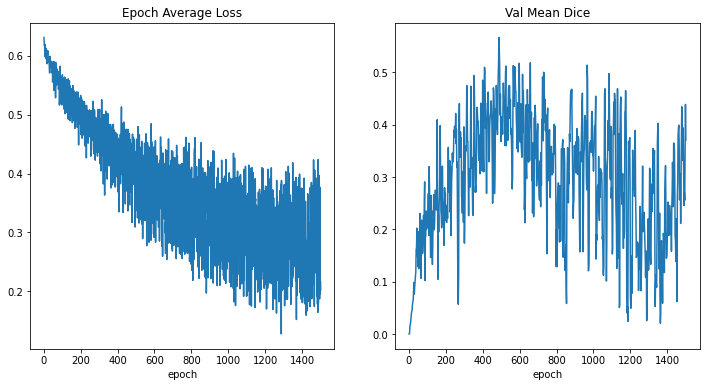

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 11 = 0.5441319942474365
../../Data_PNB/annotations_yuri/4. 222A_Video 2_cropM.nii.gz


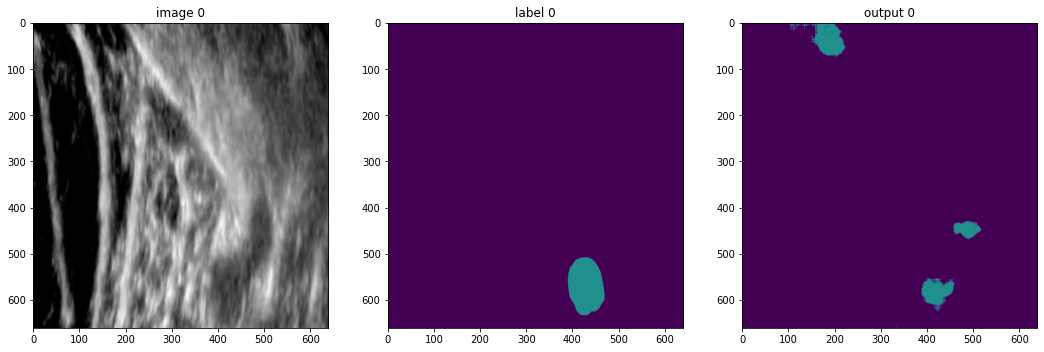

../../Data_PNB/annotations_yuri/5. 191 AC_Video 5_cropM.nii.gz


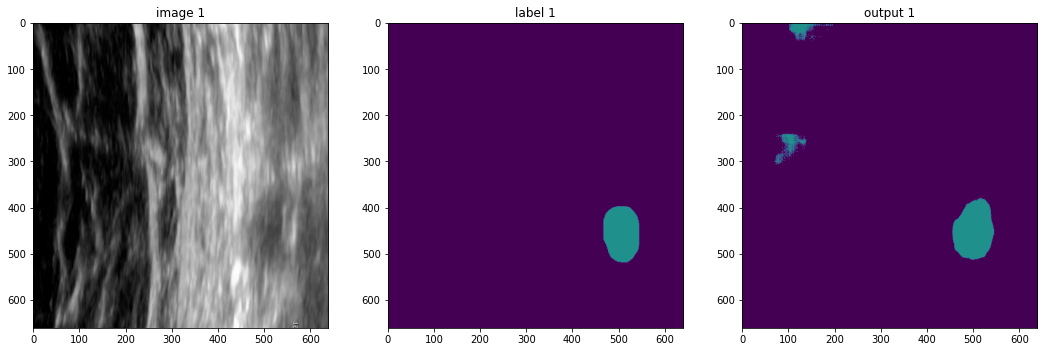

Loading dataset: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]

VFOLD = 12 of 12


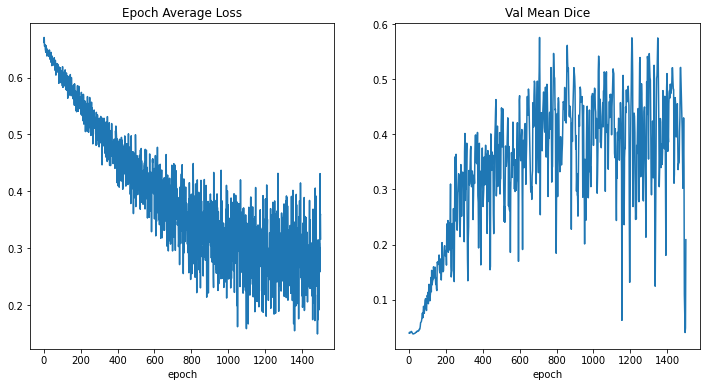

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Average test dice score for Vfold 12 = 0.5976141691207886
../../Data_PNB/annotations_yuri/5. 153 AC_Video 3_cropM.nii.gz


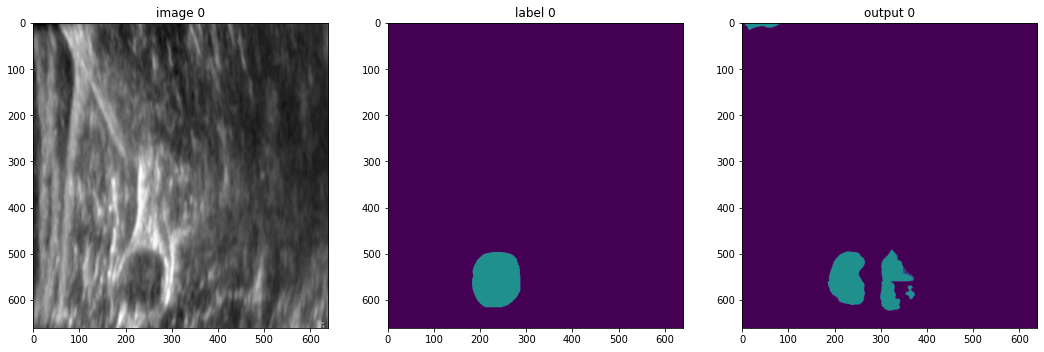

In [10]:
for i in range(0,num_folds,num_devices):
    test_ds = CacheDataset(data=test_files[i], transform=test_transforms,cache_rate=1.0, num_workers=num_workers_te)
    test_loader = DataLoader(test_ds, batch_size=batch_size_te, num_workers=num_workers_te)
    plot_vfold_training_curves(i,test_loader)
    test_loader.dataset._cache.clear()

In [11]:
import ipyparams
currentNotebook = "ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s.ipynb"
exp = "ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s-Val80_20-SlidingInference_withAvgTestDice"

from datetime import datetime
now = datetime.now()
print(str(currentNotebook))
experimentName = exp+now.strftime("-%Y.%m.%d_%H.%M")
print(experimentName)
cmd = "jupyter nbconvert "+currentNotebook+" --output "+experimentName+" --to pdf"
import subprocess
subprocess.call(cmd, shell=True)

<IPython.core.display.Javascript object>

ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s.ipynb
ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s-Val80_20-SlidingInference_withAvgTestDice-2022.05.31_13.03


[NbConvertApp] Converting notebook ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s.ipynb to pdf
[NbConvertApp] Support files will be in ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s-Val80_20-SlidingInference_withAvgTestDice-2022.05.31_13.03_files/
[NbConvertApp] Making directory ./ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s-Val80_20-SlidingInference_withAvgTestDice-2022.05.31_13.03_files
[NbConvertApp] Making directory ./ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s-Val80_20-SlidingInference_withAvgTestDice-2022.05.31_13.03_files
[NbConvertApp] Making directory ./ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s-Val80_20-SlidingInference_withAvgTestDice-2022.05.31_13.03_files
[NbConvertApp] Making directory ./ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s-Val80_20-SlidingInference_withAvgTestDice-2022.05.31_13.03_files
[NbConvertApp] Making directory ./ExampleTest-3D-PNB-RawFrame_StdOverTime-320x640-32s-Val80_20-SlidingInference_withAvgTestDice-2022.05.31

0